In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# PREPROCESSING

In [6]:
img_size=256
BATCH_size=32
channels=3


In [36]:
import os
import cv2
import numpy as np
BASE_PATH = '/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/train'
unique_classes = os.listdir(BASE_PATH)
class_index = [unique_classes[0], unique_classes[1]] 

In [8]:
import tensorflow as tf
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/train", 
    shuffle=True,
    image_size=(img_size, img_size),
    batch_size=BATCH_size
)

Found 8116 files belonging to 2 classes.


In [9]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/val", 
    shuffle=True,
    image_size=(img_size, img_size),
    batch_size=BATCH_size
)

Found 900 files belonging to 2 classes.


In [10]:
class_names=dataset.class_names
class_names

['benign', 'malignant']

In [11]:
len(dataset)

254

In [12]:
254*32

8128

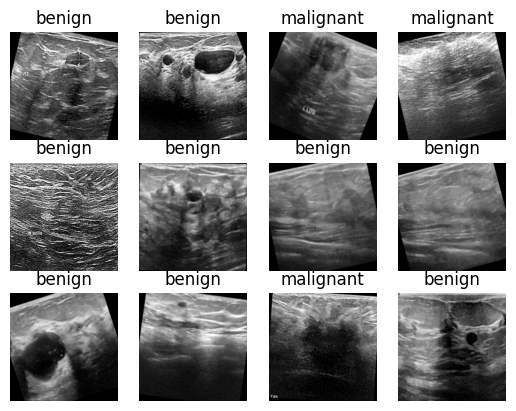

In [13]:
import matplotlib.pyplot as plt
for img_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(img_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
        #print(label_batch.numpy())

In [14]:
train_size=0.9
len(dataset)*train_size

228.6

In [15]:
train_ds= dataset.take(228)
len(train_ds)

228

In [16]:
val_ds=dataset.skip(228) 
len(val_ds)

26

**Shuffle the data into train and val**


In [17]:
def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    # Calculate the number of training samples
    train_size = int(train_split * ds_size)

    # Calculate the number of validation samples
    val_size = ds_size - train_size  # Allocate the rest to validation

    # Create the training dataset
    train_ds = ds.take(train_size)

    # Create the validation dataset
    val_ds = ds.skip(train_size).take(val_size)

    return train_ds, val_ds


In [46]:
train_ds,val_ds=get_dataset_partitions_tf(dataset)

In [47]:
len(train_ds)

228

In [48]:
len(val_ds)

26

**When gpu is loading a batch of image then the prefetch fun will allow the cpu to load the next batch and store in cache**

In [49]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Define the Preprocessing 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Image size for resizing
img_size = 128  # Example size

# Preprocessing pipeline
preprocessing_pipeline = tf.keras.Sequential([
    layers.Resizing(img_size, img_size),      # Resize
    layers.Rescaling(1.0 / 255),             # Rescale
    layers.RandomFlip("horizontal_and_vertical"),  # Random flip
    layers.RandomRotation(0.2)              # Random rotation
])


Load the Original Image

In [ ]:
# Load an image (replace with your image path)
image_path = "/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/train/malignant/malignant (100)-rotated1.png"
original_image = tf.keras.preprocessing.image.load_img(image_path)
original_image = tf.keras.preprocessing.image.img_to_array(original_image)  # Convert to array


 Apply the Preprocessing

In [ ]:
# Preprocess the image
preprocessed_image = preprocessing_pipeline(tf.expand_dims(original_image, 0))  # Add batch dimension
preprocessed_image = tf.squeeze(preprocessed_image)  # Remove batch dimension


Display the Comparison

In [ ]:
# Plot the original and preprocessed images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(2, 4, 1)
plt.imshow(original_image.astype("uint8"))
plt.title("Before Preprocessing")
plt.axis("off")

# Preprocessed image
plt.subplot(2, 4, 2)
plt.imshow(preprocessed_image.numpy())
plt.title("After Preprocessing")
plt.axis("off")

plt.show()


**Resizing the image.Even after the image is already 256 then also to make sure that while training the model only images with 256*256 are entered this fun will take care of that**

In [18]:
import tensorflow as tf
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(img_size, img_size),
    layers.Rescaling(1.0 / 255)
])

**DATA AUGMENTATION:if any image is given as input to and is inverted or converged etc then our model can detect it**


In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(img_size, img_size),
    layers.Rescaling(1.0 / 255)
])

In [20]:
data_aug=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
    
])

# CNN MODEL

In [53]:
from tensorflow.keras import layers, models

# Define your input shape without the batch size
input_shape = (img_size, img_size, channels)
n_classes = 2

# Assuming resize_and_rescale and data_aug are preprocessing layers
model = models.Sequential([
    layers.InputLayer(shape=input_shape),  # Use `shape` instead of `input_shape`
    resize_and_rescale,  # Preprocessing layer
    data_aug,            # Data augmentation layer
    layers.Conv2D(32, (3, 3), activation='relu', name="conv2d_1"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', name="conv2d_2"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', name="conv2d_3"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', name="conv2d_4"),  # Verify layer name
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', name="conv2d_5"),  # Last Conv layer
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# No need to call model.build() since input shape is defined

In [54]:
input_shape

(256, 256, 3)

In [55]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,826 (1.06 MB)

 Trainable params: 277,826 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',           
    patience=5,                   
    restore_best_weights=True     
)

In [57]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy'] 
)

In [58]:
EPOCHS = 50
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_size,       
    verbose=1,                   
    validation_data=val_ds,      
    callbacks=[early_stopping]   
)

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.6381 - loss: 0.6242 - val_accuracy: 0.7921 - val_loss: 0.4276
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.7902 - loss: 0.4380 - val_accuracy: 0.8438 - val_loss: 0.3441
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8258 - loss: 0.3621 - val_accuracy: 0.8329 - val_loss: 0.3225
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8369 - loss: 0.3383 - val_accuracy: 0.8450 - val_loss: 0.3020
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8571 - loss: 0.2913 - val_accuracy: 0.9219 - val_loss: 0.2136
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8851 - loss: 0.2610 - val_accuracy: 0.9183 - val_loss: 0.2133
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8871 - loss: 0.2391 - val_accuracy: 0.9123 - val_loss: 0.2143
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9110 - loss: 0.2057 - val_acc

# CNN ANALYSIS

In [29]:
scores=model.evaluate(test_ds)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.7224 - loss: 0.5321


In [30]:
scores

[0.538695216178894, 0.7222222089767456]

In [31]:
history.params

{'verbose': 1, 'epochs': 1, 'steps': 228}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
CNN_train_acc=history.history['accuracy']
print("Training Accuracy:", CNN_train_acc[-1])

Training Accuracy: 0.6883223652839661


In [34]:
CNN_val_acc = history.history['val_accuracy']
print("Validation Accuracy:", CNN_val_acc[-1])

Validation Accuracy: 0.7584134340286255


In [35]:
cnn_acc= history.history['accuracy']
cnn_val_acc= history.history['val_accuracy']
cnn_loss= history.history['loss']
cnn_val_loss= history.history['val_loss']

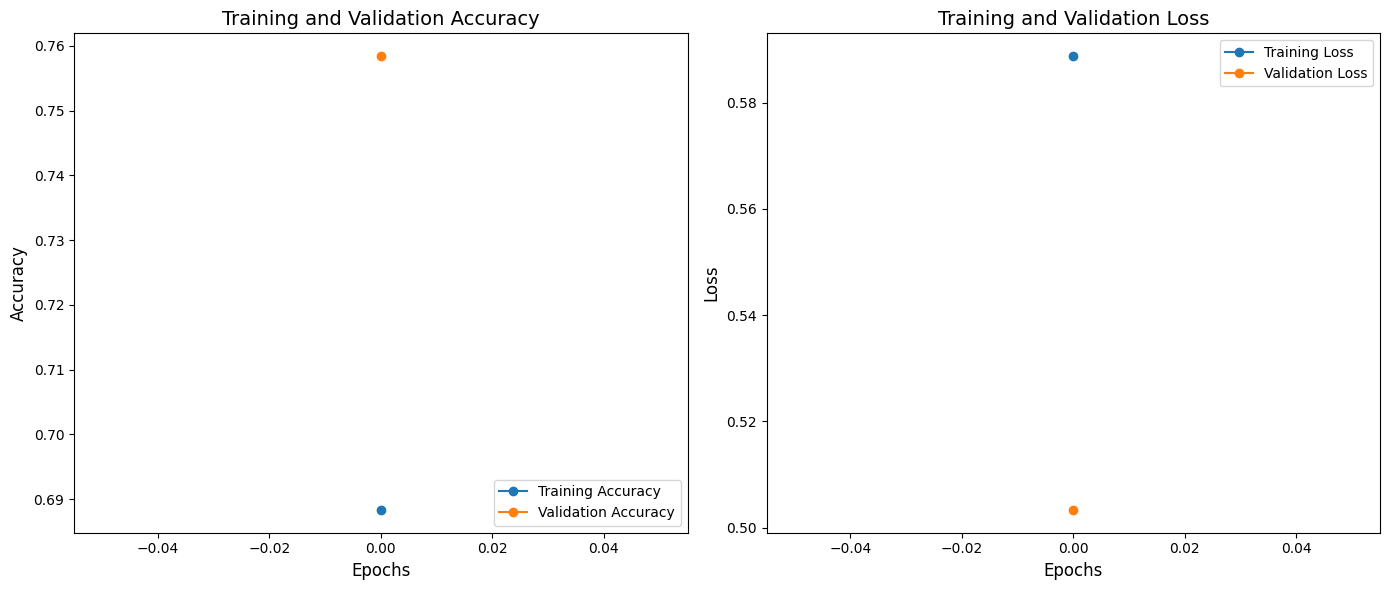

In [36]:
# Get the actual number of epochs run
actual_epochs = len(history.history['loss'])

# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(actual_epochs), history.history['accuracy'], label='Training Accuracy', marker='o', markevery=5, linewidth=1.5)
plt.plot(range(actual_epochs), history.history['val_accuracy'], label='Validation Accuracy', marker='o', markevery=5, linewidth=1.5)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=10)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(actual_epochs), history.history['loss'], label='Training Loss', marker='o', markevery=5, linewidth=1.5)
plt.plot(range(actual_epochs), history.history['val_loss'], label='Validation Loss', marker='o', markevery=5, linewidth=1.5)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [37]:
# Evaluate accuracy on the validation set
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy:.2f}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7199 - loss: 0.5360
Validation Accuracy: 0.76


In [38]:
from sklearn.metrics import classification_report
import numpy as np

# Extract true labels and predictions from the validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())                   # True labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted class indices

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


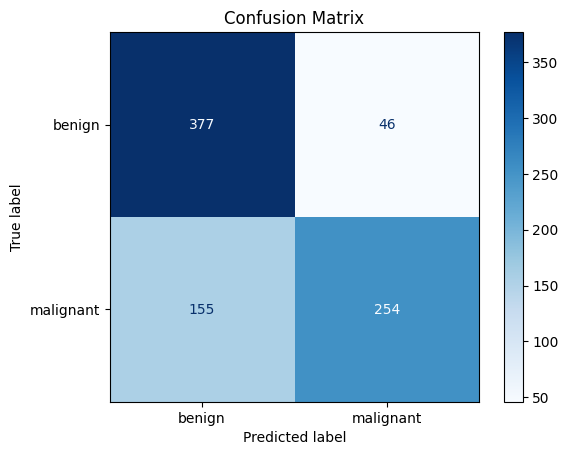

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get the true labels and predicted labels
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()


In [40]:
# Evaluate model and print validation metrics
val_metrics = model.evaluate(val_ds, return_dict=True)
print("Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.2f}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7342 - loss: 0.5494
Validation Metrics:
accuracy: 0.76
loss: 0.50


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

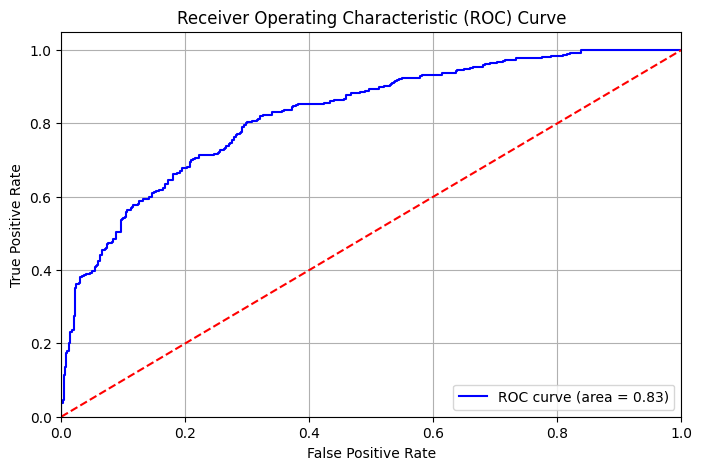

In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras import models, layers
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)  # Get predicted probabilities
    y_true.extend(labels.numpy())   # True labels
    y_pred.extend(preds[:, 1])      # Get the probabilities for the positive class

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (chance level)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# RESNET MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
resnet_model= Sequential()

pretrained_model=tf.keras.applications.ResNet50(include_top=False,
                                               input_shape=(256,256,3),
                                               pooling='avg',
                                               classes=2,
                                               weights='imagenet')
for layer in pretrained_model.layers: 
    layer.trainable = False
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512,activation='relu'))
resnet_model.add(Dense(2,activation='softmax'))


In [ ]:
resnet_model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',           
    patience=5,                   
    restore_best_weights=True     
)

In [ ]:
from tensorflow.keras.optimizers import Adam

resnet_model.compile(optimizer=Adam(),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=['accuracy'])

In [ ]:
EPOCHS=50
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping] 
)

# RESNET ANALYSIS

In [ ]:
scores_resnet=resnet_model.evaluate(test_ds)

In [ ]:
scores_resnet

In [ ]:
history_resnet.params

In [ ]:
history_resnet.history['accuracy']

In [ ]:
Resnet_train_acc=history_resnet.history['accuracy']
print("Training Accuracy:", Resnet_train_acc[-1])


In [ ]:
Resnet_val_acc= history_resnet.history['val_accuracy']
print("Validation Accuracy:", Resnet_val_acc[-1])

In [ ]:
resnet_acc= history_resnet.history['accuracy']
resnet_val_acc= history_resnet.history['val_accuracy']
resnet_loss= history_resnet.history['loss']
resnet_val_loss= history_resnet.history['val_loss']

In [ ]:
# Get the number of epochs actually run (it will be less than or equal to EPOCHS)
epochs_run = len(history_resnet.history['accuracy'])

# Plot Training and Validation Accuracy
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs_run), history_resnet.history['accuracy'], label='Training Accuracy',marker='o')
plt.plot(range(epochs_run), history_resnet.history['val_accuracy'], label='Validation Accuracy',marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss

plt.subplot(1, 2, 2)
plt.plot(range(epochs_run), history_resnet.history['loss'], label='Training Loss',marker='o')
plt.plot(range(epochs_run), history_resnet.history['val_loss'], label='Validation Loss',marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')


In [ ]:
# Evaluate accuracy on the validation set
val_loss, val_accuracy = resnet_model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy:.2f}")


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Extract true labels and predictions from the validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = resnet_model.predict(images)
    y_true.extend(labels.numpy())                   # True labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted class indices

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get the true labels and predicted labels
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(resnet_model.predict(images), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')

# Remove the grid
plt.grid(False)

plt.title("Confusion Matrix")
plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras import models, layers
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = resnet_model.predict(images)  # Get predicted probabilities
    y_true.extend(labels.numpy())   # True labels
    y_pred.extend(preds[:, 1])      # Get the probabilities for the positive class

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (chance level)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# Evaluate model and print validation metrics
val_metrics = resnet_model.evaluate(val_ds, return_dict=True)
print("Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.2f}")


# EFFICIENT NET MODEL

In [ ]:
!pip install efficientnet


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
import efficientnet.tfkeras as efn

base_model = efn.EfficientNetB0(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
predictions = Dense(1, activation="sigmoid")(x)
model_efficientNet = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model_efficientNet.compile(optimizer=RMSprop(learning_rate=0.0001, decay=1e-6), 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',          
    patience=5,                  
    restore_best_weights=True     
)

In [ ]:
history_efficientNet = model_efficientNet.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=100,
    epochs=EPOCHS,
    callbacks=[early_stopping] 
)

# EFFICIENT NET ANALYSIS

In [ ]:
scores_efficientNet=model_efficientNet.evaluate(test_ds)

In [ ]:
scores_efficientNet

In [ ]:
history_efficientNet.params

In [ ]:
history_efficientNet.history['accuracy']

In [ ]:
Eff_train_acc = history_efficientNet.history['accuracy']
print("Training Accuracy:", Eff_train_acc[-1])

In [ ]:
Eff_val_acc = history_efficientNet.history['val_accuracy']
print("Validation Accuracy:", Eff_val_acc[-1])

In [ ]:
efficientNet_acc= history_efficientNet.history['accuracy']
efficientNet_val_acc= history_efficientNet.history['val_accuracy']
efficientNet_loss= history_efficientNet.history['loss']
efficientNet_val_loss= history_efficientNet.history['val_loss']

In [ ]:
# Determine the number of epochs actually run
epochs_run = len(efficientNet_acc)

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs_run), efficientNet_acc, label='Training Accuracy', marker='o')
plt.plot(range(epochs_run), efficientNet_val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs_run), efficientNet_loss, label='Training Loss', marker='o')
plt.plot(range(epochs_run), efficientNet_val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [ ]:
# Evaluate accuracy on the validation set
val_loss, val_accuracy = model_efficientNet.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy:.2f}")


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Extract true labels and predictions from the validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model_efficientNet.predict(images)
    y_true.extend(labels.numpy())                   # True labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted class indices

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get the true labels and predicted labels
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model_efficientNet.predict(images), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')

# Remove the grid
plt.grid(False)

plt.title("Confusion Matrix")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, test_ds):
    y_true = []
    y_pred = []
    
    # Get predictions and true labels
    for images, labels in test_ds:
        preds = model_efficientNet.predict(images)         # Model predictions
        y_true.extend(labels.numpy())         # True labels
        y_pred.extend(preds.flatten())        # Flatten predictions for positive class
    
    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (chance level)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Usage Example:
# Assuming `model` is your trained model and `test_ds` is your test dataset
plot_roc_curve(model, test_ds)


In [ ]:
# Evaluate model and print validation metrics
val_metrics = model_efficientNet.evaluate(val_ds, return_dict=True)
print("Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.2f}")


# COMPARATIVE STUDY

In [ ]:
import matplotlib.pyplot as plt

# Evaluate models and extract accuracy
scores = model.evaluate(test_ds)
scores_resnet = resnet_model.evaluate(test_ds)
scores_efficientNet = model_efficientNet.evaluate(test_ds)

# Assuming the accuracy is the second value in the `scores` array
accuracy_model = scores[1]
accuracy_resnet = scores_resnet[1]
accuracy_efficientNet = scores_efficientNet[1]

# Create a list of model names and corresponding accuracies
model_names = ['Base Model', 'ResNet', 'EfficientNet']
accuracies = [accuracy_model, accuracy_resnet, accuracy_efficientNet]

# Plotting the accuracies on a bar graph
plt.figure(figsize=(6, 4))  # Decreased figure size
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange'], width=0.4)  # Reduced bar width

# Adding titles and labels
plt.title('Test Accuracy Comparison of Models', fontsize=12)
plt.xlabel('Models', fontsize=10)
plt.ylabel('Test Accuracy', fontsize=10)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Example accuracy and validation accuracy for the models
# Replace these with your actual values
models = ['CNN', 'ResNet', 'EfficientNet']
# Assuming CNN_train_acc, Resnet_train_acc, Eff_train_acc are lists with accuracy per epoch
# Use the last value (or final accuracy) for each model
accuracy = [CNN_train_acc[-1], Resnet_train_acc[-1], Eff_train_acc[-1]]  # Final Training accuracy for CNN, ResNet, and EfficientNet
val_accuracy = [CNN_val_acc[-1], Resnet_val_acc[-1], Eff_val_acc[-1]]  # Final Validation accuracy for CNN, ResNet, and EfficientNet

# Set Seaborn style and customize the background
sns.set_style("whitegrid")
plt.rcParams['axes.facecolor'] = '#f7f7f7'  # Off-white background color

# Setting up the bar positions
x = np.arange(len(models))  # the label locations
width = 0.2  # Smaller bar width

# Create the bar chart
fig, ax = plt.subplots(figsize=(6, 4))  # Smaller figure size
bars1 = ax.bar(x - width/2, accuracy, width, label='Training Accuracy', color='black')
bars2 = ax.bar(x + width/2, val_accuracy, width, label='Validation Accuracy', color='red')

# Add labels, title, and legend
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Comparative Study of Model Accuracy', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=10)
ax.legend(fontsize=10, loc='lower right')

# Annotate bars with values
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3),  # Offset by 3 points
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


# IMAGE PREDICTION AND PERCENTAGE CALCULATION

In [59]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2

# Assuming your model is already trained and compiled
# If not, you can load a saved model using tf.keras.models.load_model('your_model_path')

# Function to preprocess the image
def get_img_array(img_path, size):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=size)
    # Convert the image to a numpy array
    array = image.img_to_array(img)
    # Expand dimensions to create a batch of size 1
    array = np.expand_dims(array, axis=0)
    return array

# Path to the image you want to visualize
img_path = '/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/val/malignant/malignant (1)-rotated1-rotated2-rotated1.png'  # Replace with your image path

# Prepare the image
img_array = get_img_array(img_path, size=(img_size, img_size))

In [60]:
# Predict the class of the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
class_names = ['benign', 'malignant']  # Ensure these match your dataset's class names
predicted_label = class_names[predicted_class]

print(f"The model predicts this image is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
The model predicts this image is: malignant


In [61]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
# Function to calculate Integrated Gradients
def integrated_gradients(model, img_array, baseline=None, num_steps=50):
    if baseline is None:
        baseline = np.zeros_like(img_array)  # Default baseline is an image of all zeros
    
    # Convert to TensorFlow tensors
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)
    
    # Create linear interpolation between baseline and image
    alphas = np.linspace(0, 1, num=num_steps)
    grads = np.zeros_like(img_array)
    
    for alpha in alphas:
        interpolated_image = baseline + alpha * (img_array - baseline)
        with tf.GradientTape() as tape:
            tape.watch(interpolated_image)
            prediction = model(interpolated_image, training=False)
        
        grads += tape.gradient(prediction, interpolated_image)
    
    # Calculate the integrated gradients
    integrated_grads = (img_array - baseline) * grads / num_steps
    return integrated_grads

In [62]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)  # Resize to target size (224, 224)
    img = img.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
    
    # Add batch dimension
    img = np.expand_dims(img, axis=0)  # Add batch dimension (1, 224, 224, 3)
    
    return img  # Return image with batch dimension

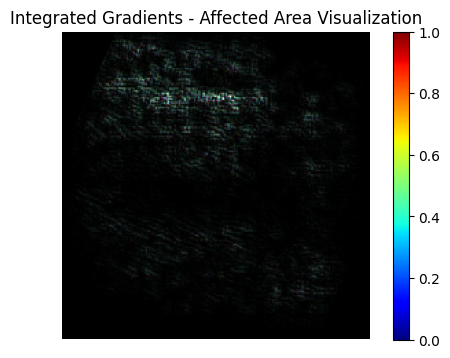

Percentage of affected cancer tissue: 5.32%


In [63]:
# Visualizing the integrated gradients and the affected area
def visualize_integrated_gradients(model, image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)
    
    # Get the integrated gradients for the image
    integrated_grads = integrated_gradients(model, img_array)
    
    # Normalize the integrated gradients to [0, 1] range
    integrated_grads = np.abs(integrated_grads)  # Take the absolute value of gradients
    integrated_grads = (integrated_grads - np.min(integrated_grads)) / (np.max(integrated_grads) - np.min(integrated_grads))

    # Visualize the integrated gradients
    plt.figure(figsize=(6, 4))
    plt.imshow(integrated_grads[0], cmap='jet')  # Remove the batch dimension for visualization
    plt.colorbar()
    plt.title("Integrated Gradients - Affected Area Visualization")
    plt.grid(False)  # Remove the grid
    plt.axis("off")  # Optional: Remove axis for a cleaner view
    plt.show()

    # Calculate the percentage of affected tissue
    threshold = 0.1  # You can adjust this threshold based on your needs
    affected_area = np.sum(integrated_grads[0] > threshold) / integrated_grads[0].size
    print(f"Percentage of affected cancer tissue: {affected_area * 100:.2f}%")

# Example usage of visualization and percentage calculation
image_path = '/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/val/malignant/malignant (1)-rotated1-sharpened-rotated32.png'  # Replace with your image path
visualize_integrated_gradients(model, image_path)
